# LSTM training

นำผลลัพธ์ที่ได้จากการ Grid Search มาทำการเทรนโมเดลพยากรณ์โดยใช้ข้อมูลฝึกทั้งหมด และเปรียบเทียบกับ Test set

## ตรวจสอบ GPU และกำหนด Hyper parameter

In [1]:
# 1. Setup & Imports Libraries
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

# Device Configuaration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using Device: {DEVICE}")

# Settings
SEED = 42
N_JOBS = 16  # Adjust based on resources. TF/R used single threaded loop or similar.

# Best Params (From Grid Search) - Update if needed
BEST_PARAMS = {
    'lstm1_units': 50,
    'lstm2_units': 32,
    'dense1_units':32,
    'dense2_units': 32,
    'learning_rate': 0.001,
    'epochs': 50,
    'window_size': 10
}

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(SEED)

Using Device: cuda


## โหลดข้อมูล และสร้างฟังก์ชั่นฝึกโครงข่ายประสาทเทียม LSTM

In [2]:
# 2. Data Loading & Preprocessing
sheet_id = "1-hzX_qRFjS7TIhWkTsrWPx7M_cFATCQxvWlRmo97Wac"
sheet_gid = "0"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_gid}"

print("Loading data")
data = pd.read_csv(csv_url)

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values('Date').reset_index(drop=True)

# Parameters
n = len(data)
n_train = 618
y = data['Y'].values
y_train = y[:n_train]
y_test = y[n_train:]
H = len(y_test) # 155
dy = np.diff(y)
dy_train = dy[:n_train - 1]

train_last_val = y_train[-1]

print(f"Data: n={n}, n_train={n_train}, H={H}")

Loading data
Data: n=773, n_train=618, H=155


/tmp/ipykernel_4241/3999843868.py:9: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)


In [3]:
# 3. Logic & Model

def create_sequences_direct(series, window, horizon, end_index):
    max_start = end_index - window - horizon + 1
    if max_start < 0:
        raise ValueError("mismatch data")
    X, y = [], []
    for i in range(max_start + 1):
        seq_x = series[i : i + window]
        target = series[i + window + horizon - 1]
        X.append(seq_x)
        y.append(target)
    return np.array(X), np.array(y)

class LSTMDirect(nn.Module):
    def __init__(self, lstm1_units, lstm2_units, dense1_units, dense2_units, window_size):
        super(LSTMDirect, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=lstm1_units, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm1_units, hidden_size=lstm2_units, batch_first=True)
        self.fc1 = nn.Linear(lstm2_units, dense1_units)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(dense1_units, dense2_units)
        self.relu2 = nn.ReLU()
        self.fc_out = nn.Linear(dense2_units, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc_out(out)
        return out

In [4]:
# 4. กำหนดฟังก์ชั่นเทรนแบบไม่ใช้ Multistep Direct เพื่อดูการ fit training set อย่างง่าย โดยการเทรนแบบพยากรณ์วันต่อวัน

def train_predict_horizon(h, full_dy, params, last_window_train, device_name, seed):
    """
    Trains model for horizon h and predicts.
    """
    seed_everything(seed + h) 
    device = torch.device(device_name)
    
    w = int(params['window_size'])
    # end_index is last index of dy_train. dy_train length = 617. Last index = 616.
    end_index = 616 
    
    X, y = create_sequences_direct(full_dy, w, h, end_index=end_index)
    
    X_t = torch.tensor(X.reshape(-1, w, 1), dtype=torch.float32).to(device)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)
    
    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model = LSTMDirect(
        int(params['lstm1_units']), int(params['lstm2_units']),
        int(params['dense1_units']), int(params['dense2_units']),
        w
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    epochs = int(params['epochs'])
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    best_model_state = None
    patience = 30
    patience_counter = 0
    
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        
        epoch_loss /= len(dataset)
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Prediction on TEST (last window of train)
    model.eval()
    test_x_t = torch.tensor(last_window_train.reshape(1, w, 1), dtype=torch.float32).to(device)
    with torch.no_grad():
        pred_diff = model(test_x_t).item()
        
    return (h, pred_diff)

# เทรน Multi Step Direct Forecasting ด้วย Training Set เพื่อพยากรณ์ Test Set 155 วัน

In [5]:
# 5. Run Multi Step Direct Training (155 Models)

print(f"Fitting {H} models")

w = int(BEST_PARAMS['window_size'])
last_window = dy_train[-w:]

start_time = time.time()

N_GPUS = torch.cuda.device_count() if torch.cuda.is_available() else 0

def safe_train(h, worker_id):
    if N_GPUS > 0:
        gpu_id = worker_id % N_GPUS
        device_str = f'cuda:{gpu_id}'
    else:
        device_str = 'cpu'
    return train_predict_horizon(h, dy, BEST_PARAMS, last_window, device_str, 42)

# prefer='threads' for CUDA compatibility
results = Parallel(n_jobs=N_JOBS, prefer="threads")(
    delayed(safe_train)(h, i) 
    for i, h in enumerate(range(1, H + 1))
)

print(f"All models fitted in {time.time() - start_time:.2f}s")

# Sort results (important because parallel may return out of order)
results.sort(key=lambda x: x[0])
pred_test_diff = np.array([r[1] for r in results])


Fitting 155 models
All models fitted in 408.11s


# เทรนแบบ Single Step และพยากรณ์ข้อมูลฝึก (Training Set) เพื่อดูการฟิตของไฮเพอร์พารามิเตอร์ที่ได้กับ Training set

In [6]:
# 6. Train 1-step Predictions บน training set


print("Training h=1 model for train set predictions")

seed_everything(42 + 1)

X1, y1 = create_sequences_direct(dy, w, 1, end_index=616)
X1_t = torch.tensor(X1.reshape(-1, w, 1), dtype=torch.float32).to(torch.device(DEVICE))
y1_t = torch.tensor(y1.reshape(-1, 1), dtype=torch.float32).to(torch.device(DEVICE))

model_h1 = LSTMDirect(
    int(BEST_PARAMS['lstm1_units']), int(BEST_PARAMS['lstm2_units']),
    int(BEST_PARAMS['dense1_units']), int(BEST_PARAMS['dense2_units']),
    w
).to(torch.device(DEVICE))

opt = optim.Adam(model_h1.parameters(), lr=BEST_PARAMS['learning_rate'])
crit = nn.MSELoss()

best_loss = float('inf')
best_state_h1 = None
patience = 30
patience_counter = 0

for ep in range(int(BEST_PARAMS['epochs'])):
    model_h1.train()
    opt.zero_grad()
    out = model_h1(X1_t)
    loss = crit(out, y1_t)
    loss.backward()
    opt.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_state_h1 = copy.deepcopy(model_h1.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

if best_state_h1 is not None:
    model_h1.load_state_dict(best_state_h1)

model_h1.eval()
with torch.no_grad():
    pred_train_diff_t = model_h1(X1_t)
    pred_train_diff = pred_train_diff_t.cpu().numpy().flatten()

print(" Train predictions computed.")

Training h=1 model for train set predictions
 Train predictions computed.


# แปลงข้อมูลกลับ บันทึก และแสดงผลลัพธ์

          Date   Actual  Train_Pred    Test_Pred
763 2025-02-03  2813.49         NaN  2492.588906
764 2025-02-04  2841.94         NaN  2495.150511
765 2025-02-05  2865.09         NaN  2490.286474
766 2025-02-06  2856.50         NaN  2491.413334
767 2025-02-07  2860.39         NaN  2477.769448
768 2025-02-10  2907.34         NaN  2469.065234
769 2025-02-11  2898.34         NaN  2471.092246
770 2025-02-12  2903.66         NaN  2477.847039
771 2025-02-13  2929.03         NaN  2486.951351
772 2025-02-14  2927.42         NaN  2496.891890
Saved predictions to LSTM_Final_Predictions.csv


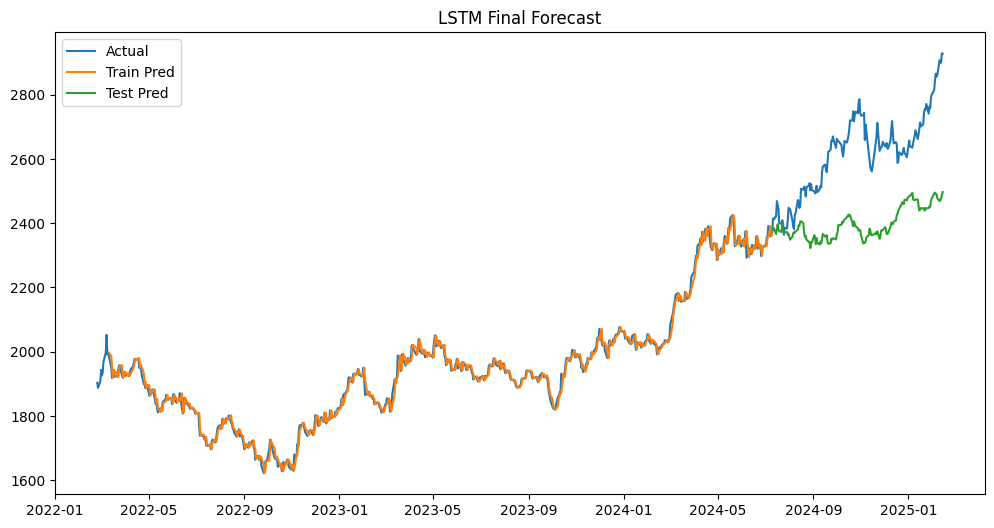

In [7]:
# 7. Reconstruction แปลงค่ากลับ

# Test Scale Reconstruction
Test_Pred = train_last_val + np.cumsum(pred_test_diff)

# Train Scale Reconstruction

train_pred_level = np.full(n_train, np.nan)
start_fill_idx = w + 1
for i, diff_val in enumerate(pred_train_diff):
    target_idx_y = start_fill_idx + i
    if target_idx_y >= n_train: break
    prev_y = y[target_idx_y - 1]
    train_pred_level[target_idx_y] = prev_y + diff_val

# DataFrames
df_final = pd.DataFrame({
    'Date': data['Date'],
    'Actual': y,
    'Train_Pred': np.full(n, np.nan),
    'Test_Pred': np.full(n, np.nan)
})

df_final.loc[:n_train-1, 'Train_Pred'] = train_pred_level
df_final.loc[n_train:n_train+H-1, 'Test_Pred'] = Test_Pred

print(df_final.tail(10))

# Save Results (Like XGBoost, path relative to notebook)
csv_filename = "LSTM_Final_Predictions.csv"
df_final.to_csv(csv_filename, index=False)
print(f"Saved predictions to {csv_filename}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_final['Date'], df_final['Actual'], label="Actual")
plt.plot(df_final['Date'], df_final['Train_Pred'], label="Train Pred")
plt.plot(df_final['Date'], df_final['Test_Pred'], label="Test Pred")
plt.title("LSTM Final Forecast")
plt.legend()
plt.show()

In [9]:
def calculate_metrics(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    yt = y_true[mask]
    yp = y_pred[mask]
    
    mae = np.mean(np.abs(yt - yp))
    rmse = np.sqrt(np.mean((yt - yp)**2))
    mape = np.mean(np.abs((yt - yp) / yt)) * 100
    return mae, rmse, mape


# Train Metrics
mae_train, rmse_train, mape_train = calculate_metrics(
    df_final['Actual'].values,
    df_final['Train_Pred'].values
)

# Test Metrics
mae_test, rmse_test, mape_test = calculate_metrics(
    df_final['Actual'].values,
    df_final['Test_Pred'].values
)


print("\nMetrics Summary:")
print(f"Train -> MAE: {mae_train:.4f} RMSE: {rmse_train:.4f} MAPE: {mape_train:.4f}%")
print(f"Test  -> MAE: {mae_test:.4f} RMSE: {rmse_test:.4f} MAPE: {mape_test:.4f}%")


Metrics Summary:
Train -> MAE: 12.9206 RMSE: 17.2815 MAPE: 0.6601%
Test  -> MAE: 221.6092 RMSE: 246.5823 MAPE: 8.2916%
